In [1]:
import rpy2
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
base = importr('base')

# the base of rpy2 plotting is matplotlib, thus we need to declare
# it inline in order to see the plots in the notebook
%matplotlib inline

# we need to activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

import numpy as np
import pandas as pd
import glob
import toml

%config IPCompleter.greedy=True

from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 200

/Users/akshay/Library/Python/3.9/lib/python/site-packages/rpy2/robjects/lib/ggplot2.py:70: UserWarning: This was designed againt ggplot2 versions starting with 3.3. but you have 3.4.2
  warnings.warn(


In [2]:
rootdir = "/Users/akshay/research/burrito"
outdirs = ["elk-2023-09-17-7b4a06e"]

In [3]:
def read_toml(cfg):
    c = toml.load(cfg)
    num_lps = len(c['machines']['logparser'])
    c['exp']['logparser']['num'] = num_lps
    return c['exp']

def merge_tomls(cfgs):
    merged_cfg = {}
    for cfg in cfgs:
        for key in cfg:
            if key in merged_cfg:
                if type(cfg[key]) != type(merged_cfg[key]):
                    raise Exception(f"mismatched config types: {cfg[key]} vs {merged_cfg[key]}")
                if type(cfg[key]) == int and merged_cfg[key] != cfg[key]:
                    raise Exception(f"int-valued configs must match: {cfg[key]} vs {merged_cfg[key]}")
                if type(cfg[key]) == list:
                    merged_cfg[key] = list(set(cfg[key]).union(set(merged_cfg[key])))
            else:
                merged_cfg[key] = cfg[key]
    return merged_cfg

tomls = {}
for outdir in outdirs:
    od = f"{rootdir}/{outdir}"
    cfgs = glob.glob(f"{od}/*.toml")
    tomls[outdir] = merge_tomls([read_toml(t) for t in cfgs])

tomls

{'elk-2023-09-17-7b4a06e': {'iterations': 1,
  'pubsub-kafka': [True, False],
  'local-fastpath': [True, False],
  'encrypt': ['allow-none', 'auto-only', 'tls-only', 'quic-only'],
  'producer': {'allow-client-sharding': [True, False],
   'msg-limit': ['30s'],
   'msg-interarrival-ms': [25, 50, 100]},
  'logingest': {'workers': [6]},
  'logparser': {'machines': [1],
   'processes-per-machine': [1, 2],
   'interval-ms': [100],
   'num': 1}}}

In [4]:
# copied from elk-app.py
import itertools
def iter_confs(exp, outdir):
    i = exp['iterations']
    prod = exp['producer']
    ing = exp['logingest']
    par = exp['logparser']
    confs = itertools.product(
        exp['pubsub-kafka'],
        exp['local-fastpath'],
        exp['encrypt'],
        prod['allow-client-sharding'],
        prod['msg-limit'],
        prod['msg-interarrival-ms'],
        ing['workers'],
        par['machines'],
        par['processes-per-machine'],
        par['interval-ms'],
        range(i),
    )
    for conf in confs:
        exp = {
                'pubsub-kafka': conf[0],
                'local-fastpath': conf[1],
                'encrypt': conf[2],
                'producer': {
                    'allow-client-sharding': conf[3],
                    'msg-limit': conf[4],
                    'msg-interarrival-ms': conf[5],
                },
                'logingest': {
                    'workers': conf[6],
                },
                'logparser': {
                    'num': par['num'],
                    'machines': conf[7],
                    'processes-per-machine': conf[8],
                    'interval-ms': conf[9],
                },
                'iteration': conf[10],
        }
        if type(exp['producer']['msg-limit']) == str:
            assert exp['producer']['msg-limit'][-1] == 's', 'time-based msg-limit must be in seconds'
            target_seconds = int(exp['producer']['msg-limit'][:-1])
            inter_seconds = float(int(exp['producer']['msg-interarrival-ms'])) / 1000
            exp['producer']['msg-limit'] = int(target_seconds / inter_seconds) * 16
        template = (
            "{rootdir}/{outdir}/"
            + "kfka={kafka}-"
            + "fp={localfp}-"
            + "cshd={client_shard}-"
            + "enc={encrypt}-"
            + "nmsg={num_msg}-"
            + "intms={msg_inter_ms}-"
            + "iwrk={ingest_workers}-"
            + "pn={parser_machines}-"
            + "pps={parser_procs}-"
            + "prpintms={parser_report_interval_ms}-"
            + "i={i}")
        desc = template.format(
            rootdir=rootdir, outdir=outdir,
            kafka=exp['pubsub-kafka'],
            localfp=exp['local-fastpath'],
            encrypt=exp['encrypt'].replace('-',''),
            client_shard=exp['producer']['allow-client-sharding'],
            num_msg=exp['producer']['msg-limit'],
            msg_inter_ms=exp['producer']['msg-interarrival-ms'],
            ingest_workers=exp['logingest']['workers'],
            parser_machines=exp['logparser']['machines'],
            parser_procs=exp['logparser']['processes-per-machine'],
            parser_report_interval_ms=exp['logparser']['interval-ms'],
            i=0,
        )
        exp['desc'] = desc
        exp['outdir'] = outdir
        yield exp

exps = list(itertools.chain.from_iterable(iter_confs(tomls[outdir], outdir) for outdir in tomls))
len(list(exps))

192

In [5]:
def read_exp(conf):
    outf_prefix = conf['desc']
    suffixes = (
        ["consumer.data", "logingest.data", "producer.data"] 
        + [f'logparser-{i}-{j}.data' for i in range(conf["logparser"]['num']) for j in range(conf['logparser']['processes-per-machine'])]
    )
    def x():
        for s in suffixes:
            df = pd.read_csv(f"{outf_prefix}-{s}")
            for c in conf:
                if type(conf[c]) == dict:
                    for i in conf[c]:
                        k = f"{c}-{i}"
                        if i == 'allow-client-sharding':
                            df[k] = 'clientshard' if conf[c][i] else 'noclientshard'
                        else:
                            df[k] = conf[c][i]
                else:
                    if c == 'pubsub-kafka':
                        df[c] = 'with-kafka' if conf[c] else 'without-kafka'
                    elif c == 'local-fastpath':
                        df[c] = 'with-fp' if conf[c] else 'without-fp'
                    else:
                        df[c] = conf[c]
            df['machine'] = s.split('.')[0]
            yield df
    return pd.concat(x())

df = pd.concat(read_exp(e) for e in exps)
pd.options.display.max_columns = 25
df

,since_start_us,tot_records,tot_bytes,records,bytes,elapsed_us,rate_records_per_sec,rate_bytes_per_sec,pubsub-kafka,local-fastpath,encrypt,producer-allow-client-sharding,producer-msg-limit,producer-msg-interarrival-ms,logingest-workers,logparser-num,logparser-machines,logparser-processes-per-machine,logparser-interval-ms,iteration,desc,outdir,machine
0,16357491,2,0,1,0,102,9773.164844,0.0,with-kafka,with-fp,allow-none,clientshard,19200,25,6,1,1,1,100,0,/Users/akshay/research/burrito/elk-2023-09-17-...,elk-2023-09-17-7b4a06e,consumer
1,16357617,3,0,1,0,183,5441.851100,0.0,with-kafka,with-fp,allow-none,clientshard,19200,25,6,1,1,1,100,0,/Users/akshay/research/burrito/elk-2023-09-17-...,elk-2023-09-17-7b4a06e,consumer
2,16357700,4,0,1,0,235,4247.745509,0.0,with-kafka,with-fp,allow-none,clientshard,19200,25,6,1,1,1,100,0,/Users/akshay/research/burrito/elk-2023-09-17-...,elk-2023-09-17-7b4a06e,consumer
3,16460762,5,0,1,0,103264,9.683847,0.0,with-kafka,with-fp,allow-none,clientshard,19200,25,6,1,1,1,100,0,/Users/akshay/research/burrito/elk-2023-09-17-...,elk-2023-09-17-7b4a06e,consumer
4,16460802,6,0,1,0,133,7494.847292,0.0,with-kafka,with-fp,allow-none,clientshard,19200,25,6,1,1,1,100,0,/Users/akshay/research/burrito/elk-2023-09-17-...,elk-2023-09-17-7b4a06e,consumer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,28696090,69,0,1,0,1502539,0.665540,0.0,without-kafka,without-fp,quic-only,noclientshard,4800,100,6,1,1,2,100,0,/Users/akshay/research/burrito/elk-2023-09-17-...,elk-2023-09-17-7b4a06e,logparser-0-1
21,31700724,70,0,1,0,3004777,0.332803,0.0,without-kafka,without-fp,quic-only,noclientshard,4800,100,6,1,1,2,100,0,/Users/akshay/research/burrito/elk-2023-09-17-...,elk-2023-09-17-7b4a06e,logparser-0-1
22,33201435,71,0,1,0,1500841,0.666293,0.0,without-kafka,without-fp,quic-only,noclientshard,4800,100,6,1,1,2,100,0,/Users/akshay/research/burrito/elk-2023-09-17-...,elk-2023-09-17-7b4a06e,logparser-0-1
23,33879953,74,0,3,0,678588,4.420941,0.0,without-kafka,without-fp,quic-only,noclientshard,4800,100,6,1,1,2,100,0,/Users/akshay/research/burrito/elk-2023-09-17-...,elk-2023-09-17-7b4a06e,logparser-0-1


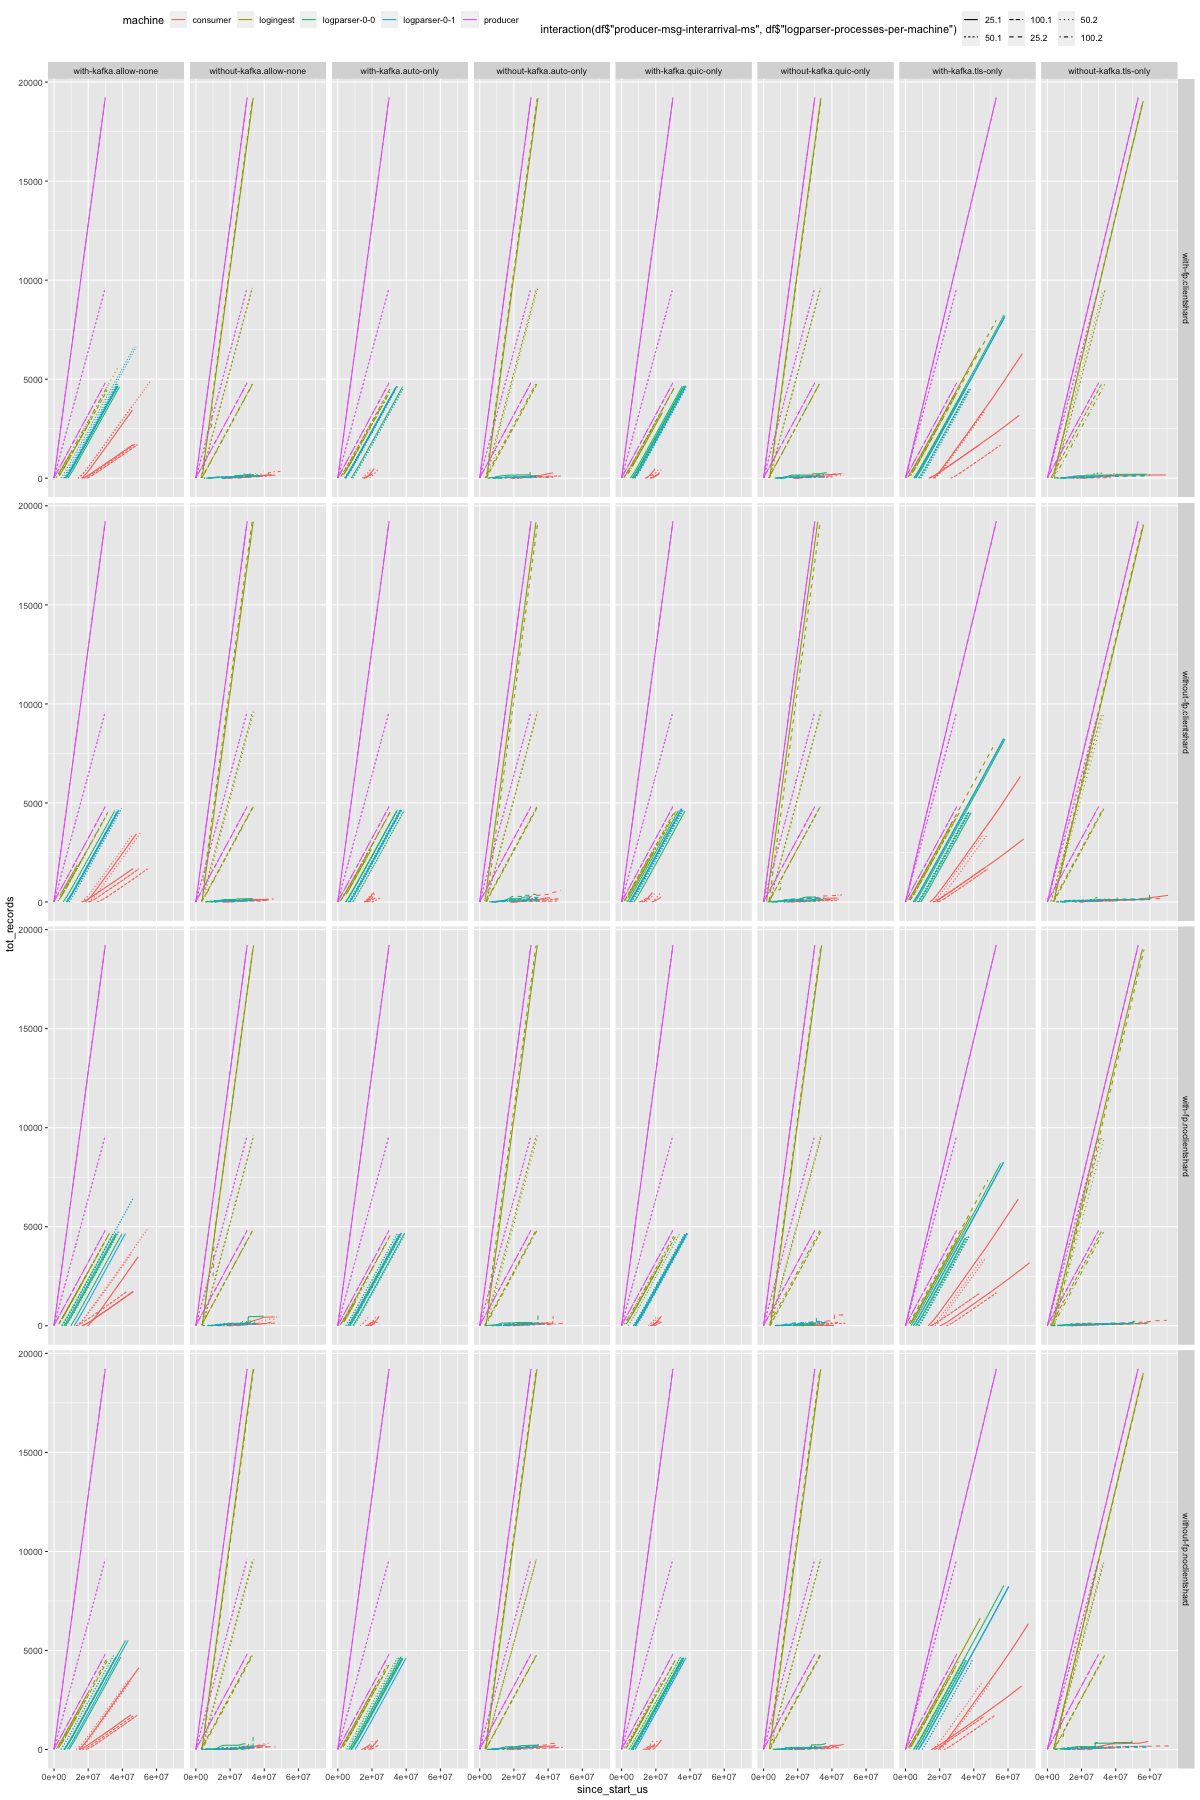

In [10]:
%%R -i df -w 1200 -h 1800

# zoom in
library(ggplot2)

ggplot(df, aes(
    x=since_start_us, 
    y=tot_records, 
    colour=machine, 
    linetype=interaction(df$"producer-msg-interarrival-ms", df$"logparser-processes-per-machine")
    )) + 
    geom_line() +
    facet_grid(
        interaction(df$"local-fastpath",df$"producer-allow-client-sharding") ~ 
        interaction(df$"pubsub-kafka",df$encrypt)) +
    theme(legend.position = "top")

Now summarize each configuration-node as its average slope. If the lines above are not straight, then representing each config-node as a single overall slope would not be a good representation.

In [37]:
def agg_group(g):
    last = g.tail(1)
    first = g.head(1)
    g_elapsed_us = last['since_start_us'].values[0] - first['since_start_us'].values[0]
    g_tot_records = last['tot_records']
    records_per_s = g_tot_records * 1e6 / g_elapsed_us
    return records_per_s

slopes_df = df.groupby([
    "machine", 
    "pubsub-kafka",
    "encrypt",
    "local-fastpath", 
    "producer-allow-client-sharding",
    "producer-msg-interarrival-ms", 
    "logparser-processes-per-machine",
    ]).apply(agg_group).reset_index(name="records_per_s")
slopes_df

,machine,pubsub-kafka,encrypt,local-fastpath,producer-allow-client-sharding,producer-msg-interarrival-ms,logparser-processes-per-machine,level_7,records_per_s
0,consumer,with-kafka,allow-none,with-fp,clientshard,25,1,1705,56.869266
1,consumer,with-kafka,allow-none,with-fp,clientshard,25,2,3428,115.573417
2,consumer,with-kafka,allow-none,with-fp,clientshard,50,1,1714,57.431626
3,consumer,with-kafka,allow-none,with-fp,clientshard,50,2,4947,116.747058
4,consumer,with-kafka,allow-none,with-fp,clientshard,100,1,1691,57.103883
...,...,...,...,...,...,...,...,...,...
859,producer,without-kafka,tls-only,without-fp,noclientshard,25,2,1200,361.909671
860,producer,without-kafka,tls-only,without-fp,noclientshard,50,1,600,320.475800
861,producer,without-kafka,tls-only,without-fp,noclientshard,50,2,600,320.497284
862,producer,without-kafka,tls-only,without-fp,noclientshard,100,1,300,160.399207


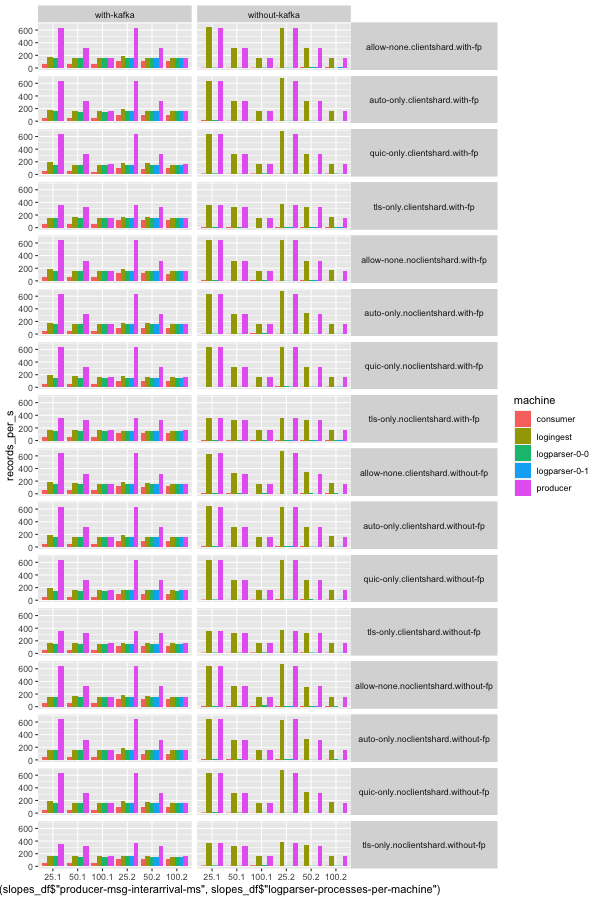

In [42]:
%%R -i slopes_df -w 600 -h 900

ggplot(slopes_df, aes(
    x=interaction(slopes_df$"producer-msg-interarrival-ms", slopes_df$"logparser-processes-per-machine"),
    y=records_per_s,
    fill=machine)) +
    geom_col(position="dodge") +
    facet_grid(interaction(encrypt, slopes_df$"producer-allow-client-sharding", slopes_df$"local-fastpath") ~ slopes_df$"pubsub-kafka") +
    theme(
        strip.text.y = element_text(angle = 0)
    )

Without kafka, adding a second parser forces the connection into service-side ordering mode. Does that help?
We consider with the other assumptions on (no kakfa, allow no encryption, allow fp, allow client sharding).

In [57]:
df_num_parsers = slopes_df[
    (slopes_df["pubsub-kafka"] == "without-kafka") &
    (slopes_df["encrypt"] == "allow-none") &
    (slopes_df["local-fastpath"] == "with-fp") &
    (slopes_df["producer-allow-client-sharding"] == "clientshard") &
    ((slopes_df["machine"] == "consumer") | (slopes_df["machine"] == "logparser-0-0") | (slopes_df["machine"] == "logparser-0-1"))
]
df_num_parsers

,machine,pubsub-kafka,encrypt,local-fastpath,producer-allow-client-sharding,producer-msg-interarrival-ms,logparser-processes-per-machine,level_7,records_per_s
96,consumer,without-kafka,allow-none,with-fp,clientshard,25,1,14,6.218014
97,consumer,without-kafka,allow-none,with-fp,clientshard,25,2,56,6.446434
98,consumer,without-kafka,allow-none,with-fp,clientshard,50,1,18,5.290087
99,consumer,without-kafka,allow-none,with-fp,clientshard,50,2,24,16.028575
100,consumer,without-kafka,allow-none,with-fp,clientshard,100,1,15,6.433191
101,consumer,without-kafka,allow-none,with-fp,clientshard,100,2,45,11.454361
480,logparser-0-0,without-kafka,allow-none,with-fp,clientshard,25,1,41,6.376837
481,logparser-0-0,without-kafka,allow-none,with-fp,clientshard,25,2,35,5.961554
482,logparser-0-0,without-kafka,allow-none,with-fp,clientshard,50,1,33,6.179915
483,logparser-0-0,without-kafka,allow-none,with-fp,clientshard,50,2,33,8.704617


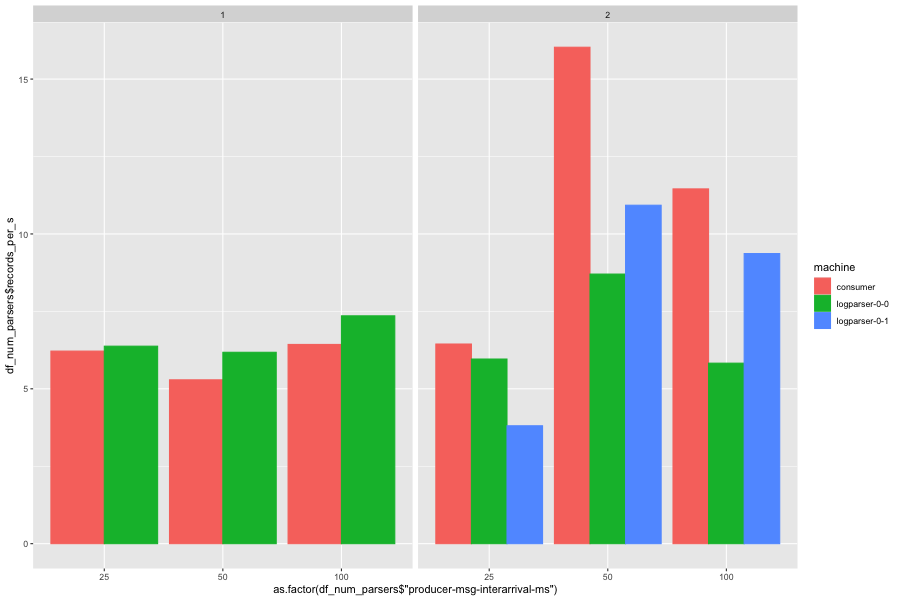

In [58]:
%%R -i df_num_parsers -w 900 -h 600

ggplot(df_num_parsers, aes(
    x = as.factor(df_num_parsers$"producer-msg-interarrival-ms"),
    y = df_num_parsers$"records_per_s",
    colour = machine, fill=machine
    )) +
    geom_col(position = "dodge") +
    facet_wrap(~df_num_parsers$"logparser-processes-per-machine")